In [8]:
import os
import pandas as pd 
import math
import nibabel as nb
import numpy as np
#pd.set_option('display.max_rows', 10)

First, load in all the subjects .nii files. Then, import the CSV file that specifies the timestamps where internal monologue is present during each video. For each video, the subject's neural timeseries file will be segmented out into 25 clips. This means that altogether, each subject will have 50 clips. 

In [42]:
inarr_data = '/Volumes/LT/phd/inarr/'

sublist = [x for x in os.listdir(inarr_data) if 'sub' in x]

timestamps = pd.read_csv('/Users/lindseytepfer/Documents/phd/inarr/monologue_timestamps.csv')

v1_subs = ['sub-1','sub-10','sub-13','sub-14','sub-17','sub-18','sub-19',
'sub-20','sub-21','sub-24','sub-25','sub-26','sub-27']
v2_subs = ['sub-2','sub-3','sub-4','sub-5','sub-6','sub-7','sub-8','sub-9',
'sub-11','sub-12','sub-15','sub-16','sub-22','sub-23', 'sub-28']

This function takes in each .nii image and the subsetted dataframe, and uses the timestamps inside of the dataframe to determine where the nii files must be trimmed. Because we're dealing with brain data, we shift the timecourse by 6 seconds to account for the hemodynamic response function. 

In [37]:
def trim_image(brain, df, snum, movie):

    for i in range(df.index.min(),df.index.max()+1):

        start = math.floor((df.loc[i, "start"] / 2) + 6)
        stop = math.ceil((df.loc[i, "stop"] /2) + 6)
        type = df.loc[i, "type"]
        version_silenced = df.loc[i, "version_silenced"]

        if snum in v1_subs:
            version = 1
        elif snum in v2_subs:
            version = 2

        if i%2 == 1: #this means its an IM segment
            if version_silenced == version:
                version = str(version)+"_silenced"

        if i != df.index[-1]:
            sub_trimmed = brain.slicer[:,:,:,start:stop]
        else:
            sub_trimmed = brain.slicer[:,:,:,start:]

        nb.save(sub_trimmed,inarr_data+snum+"/segmented_files/"+snum+"_"+movie+"_clip-"+str(i)+"_"+type+"_version-"+str(version)+".nii.gz")
    
    return (print("trimming complete."))

In [43]:
for sub in sublist[24:]:
    print(sub)
    sub_files = [x for x in os.listdir(inarr_data+sub) if '.nii.gz' in x]

    for f in sub_files:
        sub_brain = nb.load(inarr_data+sub+os.sep+f)

        if 'physical' in f:
            phys_df = timestamps[(timestamps.movie == 'physical')].copy()
            trim_image(sub_brain, phys_df, sub, 'physical')

        elif 'stutterer' in f:
            stut_df = timestamps[(timestamps.movie == 'stutterer')].copy().reset_index()
            trim_image(sub_brain, stut_df, sub, 'stutterer')



sub-16
trimming complete.
trimming complete.
sub-29
sub-2
trimming complete.
trimming complete.
sub-5
trimming complete.
trimming complete.
sub-4
trimming complete.
trimming complete.
sub-3
trimming complete.
trimming complete.


## <font color='hotpink'> Univariate analysis </font>

Next, we mask each clip into 400 different sub-regions (parcels) of the brain. In doing so, we create a 400-row dataframe for each clip, where each row is a parcel, and the column lengths are variable dependent upon the size of a given parcel. 

Afterwards, for each participant, we take the parcel data related to the internal monologue segments, and compute the mean for each clip. 

Take the clips from the (we ignore the non-internal monologue moments for this analysis) and take the silenced or unsilenced and you can compute a mean for each one of those clips, averaging both voxels within a parcel, and across time. We get 12 values per participant per parcel. 

In [ ]:
import nilearn
from nilearn import datasets
import nilearn.image as image
from nilearn.maskers import NiftiMasker

In [ ]:
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
                                                    data_dir=None, base_url=None, resume=True, verbose=1)
'''
From the documentation:
The list of labels does not contain ‘Background’ by default. 
To have proper indexing, you should either manually add ‘Background’ to the list of labels:
'''

schaefer_atlas.labels = np.insert(schaefer_atlas.labels, 0, "Background")

In [ ]:
# holding all 400 parcel masks in memory; takes apprx 2m13s
mask_list = []

for p in range(1,402): #402

    try:
        # create a new image from the parcel coordinate data 
        parcel = nilearn.image.new_img_like(schaefer_atlas.maps, nilearn.image.get_data(schaefer_atlas.maps) == p) #hold the parcel masks in memory 
        
        #convert the image into a mask
        masker = NiftiMasker() 
        parcel_mask = masker.fit(parcel)

        #throw the mask into a list
        mask_list.append(parcel_mask)
    
    except: 
        print("out of range, p=", p)
        continue

In [ ]:
for ix,mask in enumerate(mask_list):
    print(ix)
    parcel_data = []
    subidlist, movielist, cliplist, versionlist, typelist = [], [], [], [], []
    
    for sub in sublist:
        print(sub)

        sub_clips = [x for x in os.listdir(xhdpath+sub+'/segmented_files/') if '_IM_' in x]
        sub_clips.sort()
    
        for clip in sub_clips:
            movie = clip.split('_')[1]
            clip_num = clip.split('_')[2]
            type = clip.split('_')[3]
            version = clip.split('_')[4].split('.')[0]

            clip_segment = nb.load(xhdpath+sub+'/segmented_files/'+clip)
            #this function takes the image's mean over time (the 4th dimension)
            clip_avg = image.mean_img(clip_segment)

            try:
                roi_data = mask.transform_single_imgs(clip_avg)
                parcel_data.append(roi_data[0])

                subidlist.append(sub)
                movielist.append(movie)
                cliplist.append(clip_num)
                versionlist.append(version.split('-')[1])
                typelist.append(type)
            except:
                print("index:", ix, sub, clip)
                
    df = pd.DataFrame(parcel_data)
    df['sub'] = subidlist
    df['movie'] = movielist
    df['clip'] = cliplist
    df['type'] = typelist
    df['version'] = versionlist
    
    df.to_csv(xhdpath+"/univariate_parcels/parcel_"+str(ix)+".csv", index=False)
    print('done')



Next, I average the voxels of each parcel, creating a reduced dataframe:

In [ ]:
parcel_paths = '/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/'
parcels = [x for x in os.listdir(parcel_paths) if '.csv' in x] #400

In [ ]:
for i in parcels:
    df = pd.read_csv(parcel_paths+i)
    ignore_columns = ['sub', 'movie', 'clip', 'type', 'version']
    voxel_columns = [x for x in df.columns if x not in ignore_columns]
    df['avg_column'] = df[voxel_columns].mean(axis=1)
    new_df = df[['avg_column', 'sub', 'movie', 'clip', 'type', 'version']]
    new_df.to_csv(parcel_paths+"averaged/"+i)

In [2]:
#quickly adding a new column to the univariate averages
uni_avg_path = '/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/averaged/'
parcels = [x for x in os.listdir(uni_avg_path) if '.csv' in x] #400


In [39]:
key = pd.read_csv("/Users/lindseytepfer/Documents/phd/inarr/silenced_key.csv")

for i in parcels:
    pname = i.split(".")[0]
    df = pd.read_csv(uni_avg_path+i, index_col=0)
    df['silenced'] = ""

    for ix in range(df.index.max()+1):
        sub = df.loc[ix, "sub"]
        m = df.loc[ix, "movie"]
        c = df.loc[ix, "clip"]

        if sub in v1_subs:
            v = 1
        elif sub in v2_subs:
            v = 2

        match = key[(key['version'] == v) & (key['clip'] == c) & (key['movie'] == m)]
        s = match['silenced'].iloc[0]
        
        df.loc[ix,'silenced'] = s
    df = df.drop(['version'], axis=1)
    df.to_csv("/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/averaged_new/"+pname+".csv", index=False)

    

### Plotting the Univariate Result
Now that we have all of our t-values, we insert them into a brain image and plot the results.

In [1]:
from statsmodels.stats.multitest import multipletests

In [27]:
from nilearn import plotting, datasets, image, surface
import nibabel as nb
from nilearn.plotting import plot_img_on_surf
from nilearn.image import new_img_like

fsaverage = datasets.fetch_surf_fsaverage()

In [5]:
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
    data_dir=None, base_url=None, resume=True, verbose=1)

schaefer_atlas.labels = np.insert(schaefer_atlas.labels, 0, "Background")

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/schaefer_2018


In [42]:
results = pd.read_csv('/Volumes/Scraplab/lindseytepfer/inarr/univariate_parcels/results/all_parcel_results.csv')
t_vals = list(results['t_value'])
results['p_value_log'] = -np.log(results['p_value'])

reject, pvals_corrected, _, _ = multipletests(
    results['p_value_log'],  # Your column of raw p-values
    #alpha=0.05,      # Significance level
    method='bonferroni'    # Holm-Bonferroni method
)

significant = np.where(pvals_corrected <= 0.05, 1, 0)


In [48]:
sum(results['p_value_log'] < 0.5)

286

In [49]:
sum(results['p_value'] < 0.5)

51

In [ ]:
atlas = nb.load(schaefer_atlas.maps) # .maps provides the path to the map
atlas_data = atlas.get_fdata()
affine = atlas.affine

mapped_data = np.zeros_like(atlas_data)
mapped_data[atlas_data == 0] = np.nan # mark
unique_regions = np.unique(atlas_data)[1:]

for i, region in enumerate(unique_regions):
    mapped_data[atlas_data == region] = t_vals[i]

#Create corrected p-value mask:
n_rois = 399

roi_data = image.get_data(atlas)  # (x,y,z) array with ROI labels
significant_mask = np.zeros_like(roi_data, dtype=np.float32)

for roi_label in range(1, n_rois+1):
    if significant[roi_label-1] == 1:  # ROI labels start at 1
        significant_mask[roi_data == roi_label] = 1  # Tag significant voxels

mask_img = new_img_like(atlas, significant_mask)

In [31]:
tval_img = nb.Nifti1Image(mapped_data, affine)
nb.save(tval_img, 'tvalue_map.nii.gz')

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/fsaverage


/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


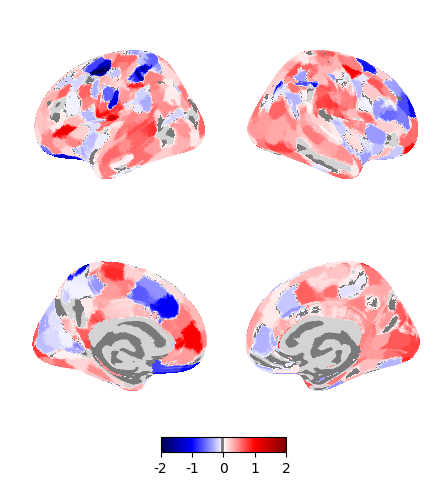

In [34]:
plotting.plot_img_on_surf(
    tval_img,"fsaverage", inflate=True,
    views=['lateral', 'medial'],  # Hemispheric views to display
    hemispheres=['left', 'right'],  # Both hemispheres
    threshold=0.05,  # Highlight significant p-values
    cmap='seismic',  # Colormap (e.g., 'viridis', 'coolwarm')
    colorbar=True,  # Show colorbar
    # vmin=0, vmax=.4, #removing these options to let it be automatic
)

plotting.show()